In [2]:
import os
for dirname, _, filenames in os.walk('/home/megatonrex/ICGPRO/dir/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/home/megatonrex/ICGPRO/dir/input/archive/captions.txt
/home/megatonrex/ICGPRO/dir/input/archive/Images/3524436870_7670df68e8.jpg
/home/megatonrex/ICGPRO/dir/input/archive/Images/500678178_26ce0f4417.jpg
/home/megatonrex/ICGPRO/dir/input/archive/Images/1022454332_6af2c1449a.jpg
/home/megatonrex/ICGPRO/dir/input/archive/Images/2535746605_8124bf4e4f.jpg
/home/megatonrex/ICGPRO/dir/input/archive/Images/2633722629_5eeb649c09.jpg
/home/megatonrex/ICGPRO/dir/input/archive/Images/2975018306_0e8da316f5.jpg
/home/megatonrex/ICGPRO/dir/input/archive/Images/2877637572_641cd29901.jpg
/home/megatonrex/ICGPRO/dir/input/archive/Images/3286222970_1fa445e38f.jpg
/home/megatonrex/ICGPRO/dir/input/archive/Images/3599392711_8264881de2.jpg
/home/megatonrex/ICGPRO/dir/input/archive/Images/2896668718_0c3cff910f.jpg
/home/megatonrex/ICGPRO/dir/input/archive/Images/1670592963_39731a3dac.jpg
/home/megatonrex/ICGPRO/dir/input/archive/Images/3565021218_d2bc1aa644.jpg
/home/megatonrex/ICGPRO/dir/input/archive/Imag

In [3]:
import os
import numpy as np
import pickle
import pydot
import graphviz
import tensorflow as tf
from keras.models import load_model
from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

2025-04-04 06:06:35.157901: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-04 06:06:35.257486: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-04 06:06:35.348574: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743746795.512270 1884717 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743746795.534276 1884717 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-04 06:06:35.736767: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [4]:
#storing the dataset in the base directory.
BASE_DIR = '/home/megatonrex/ICGPRO/dir/input/archive'
#storing the processed files like pickle file in the working directory.
WORKING_DIR  = '/home/megatonrex/ICGPRO/dir/working'

In [ ]:
model = VGG16()
#removing the last prediction layer
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
print(model.summary())

In [ ]:
#extracting features from the image
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    # img_path = directory + '/' + img_name
    img_path = os.path.join(directory, img_name)
    #resizing the image.
    image = load_img(img_path, target_size= (224,224))
    #transforimg the image in to numbers.
    image = img_to_array(image)
    # image = image.reshape((1, image.shape[0], image.shape[1], image.shape(2)))
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    feature = model.predict(image, verbose = 0)
    image_id = img_name.split('.')[0]
    features[image_id] = feature

In [ ]:
# storing the data
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [5]:
# loading the data
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [6]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [7]:
mapping = {}
for line in tqdm(captions_doc.split('\n')):
    #it will split the image and its corresponding caption.
    tokens = line.split(',')
    #here we are skipping those captions which have length less than 2.
    if len(line) < 2:
        continue
    img_id, caption = tokens[0], tokens[1]
    img_id = img_id.split('.')[0]
    #formatting the characters by joining them in a single string.
    caption = "".join(caption)
    #making an img a key of a list if not present in the mapping dictionary.
    if img_id not in mapping:
        mapping[img_id] = []
    mapping[img_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [8]:
len(mapping)

8091

In [9]:
def cleaning(mapping):
    for key, captions in mapping.items():
        #iterates the number of captions in each list times.
        for i in range(len(captions)):
            #taking one caption at a time.
            caption = captions[i]
            caption = caption.lower()
            caption = caption.replace('[^A-Za-z]', '')
            caption = caption.replace('\s+', ' ')
            #adding start and end tag in each caption and removing single digit words.
            caption = 'startseq '+ " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

<>:9: SyntaxWarning: invalid escape sequence '\s'
<>:9: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_1884717/3473603847.py:9: SyntaxWarning: invalid escape sequence '\s'
  caption = caption.replace('\s+', ' ')


In [10]:
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [11]:
cleaning(mapping)

In [12]:
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [13]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [14]:
len(all_captions)

40455

In [15]:
all_captions[:2]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq']

In [16]:
tokenizer = Tokenizer()
#looking at all the captions and remembering every single word in it. Alse giving each word a unique number, like a tag.
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1
word_index = tokenizer.word_index
print(word_index)

{'startseq': 1, 'endseq': 2, 'in': 3, 'the': 4, 'on': 5, 'is': 6, 'and': 7, 'dog': 8, 'with': 9, 'man': 10, 'of': 11, 'two': 12, 'white': 13, 'black': 14, 'boy': 15, 'are': 16, 'woman': 17, 'girl': 18, 'to': 19, 'wearing': 20, 'people': 21, 'at': 22, 'water': 23, 'young': 24, 'red': 25, 'brown': 26, 'an': 27, 'his': 28, 'blue': 29, 'dogs': 30, 'running': 31, 'through': 32, 'playing': 33, 'shirt': 34, 'while': 35, 'down': 36, 'little': 37, 'standing': 38, 'ball': 39, 'grass': 40, 'person': 41, 'child': 42, 'snow': 43, 'jumping': 44, 'over': 45, 'three': 46, 'front': 47, 'sitting': 48, 'small': 49, 'up': 50, 'a': 51, 'field': 52, 'holding': 53, 'large': 54, 'group': 55, 'by': 56, 'green': 57, 'yellow': 58, 'children': 59, 'walking': 60, 'men': 61, 'her': 62, 'into': 63, 'beach': 64, 'air': 65, 'near': 66, 'jumps': 67, 'mouth': 68, 'street': 69, 'runs': 70, 'for': 71, 'another': 72, 'riding': 73, 'from': 74, 'its': 75, 'as': 76, 'bike': 77, 'stands': 78, 'girls': 79, 'one': 80, 'outside':

In [17]:
pickle.dump(tokenizer, open(os.path.join('frontend/', 'tokenizer.pkl'), 'wb'))

In [18]:
max_length = max(len(caption.split()) for caption in all_captions)
max_length

31

In [19]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

# val_split = int(len(train) * 0.10)
# val = train[:val_split]  # 10% of training set for validation
# train = train[val_split:]  # Remaining 90% of train set for actual training

# print(f"Training images: {len(train)}, Validation images: {len(val)}, Test images: {len(test)}")

In [20]:
#generating a generator to get data in batch(this prevents session from crashing)
def dataGenerator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    #creating 3 lists for storing image features, predicted words & next words to predict.
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            for caption in captions:
                #tokenizing the caption in a sequence of indices using word vectors
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    #storing the predicted words(input for the model) and stores the output(next word to be predicted)
                    in_seq, out_seq = seq[:i], seq[i]
                    #insuring padding according to the length of the max length caption because LSTM take inputs of same size.
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    #one hot encoding is important because the normal word vector will make problem such as assuming one word import than other.
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n==batch_size:
                X1,X2,y = np.array(X1), np.array(X2), np.array(y)
                #returning the predicted output till the particular point
                yield (tf.convert_to_tensor(X1, dtype=tf.float32), tf.convert_to_tensor(X2, dtype=tf.float32)), tf.convert_to_tensor(y, dtype=tf.float32)
                #reseting everything to 0 so it can start with the new batch
                X1, X2, y = list(), list(), list()
                n = 0  

2025-04-04 06:06:49.358820: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


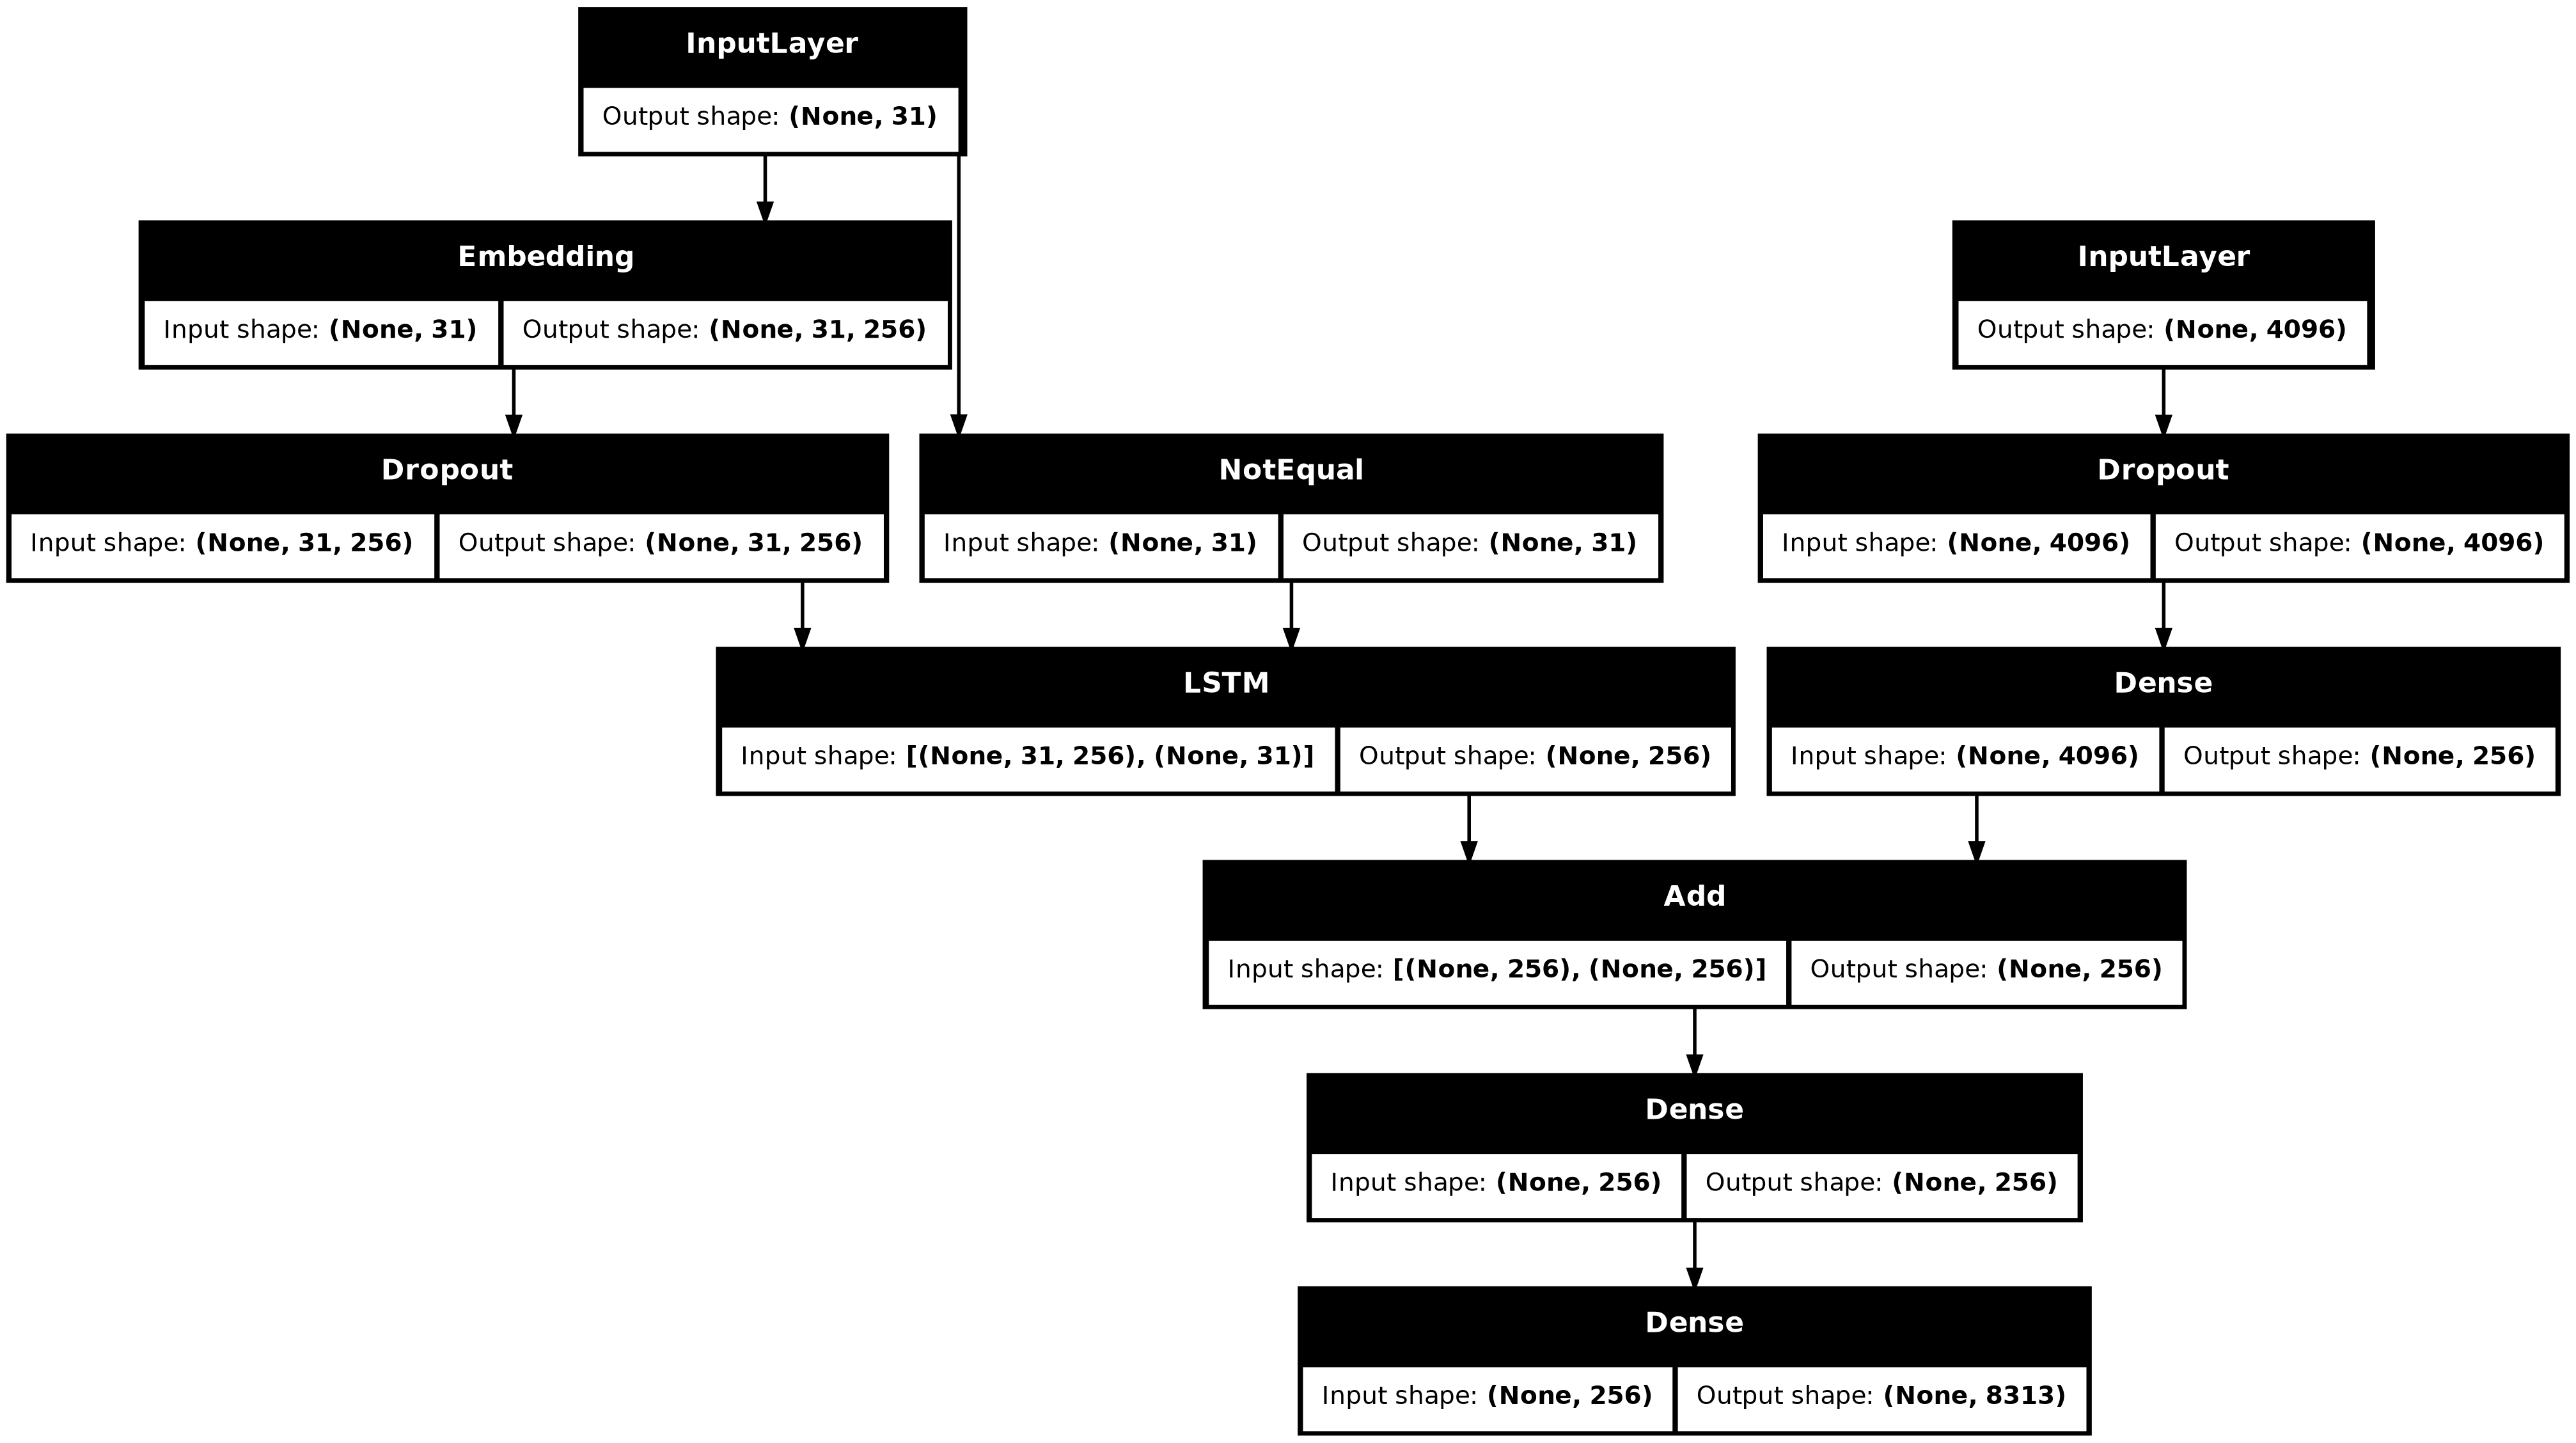

In [21]:
#encoder
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

#sequence feature layer
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

#decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs= outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

#plotting the sequence flow
plot_model(model, show_shapes=True)

In [ ]:
# from keras.callbacks import EarlyStopping, ModelCheckpoint

# epochs = 30
# batch_size = 4
# steps = len(train) // batch_size

# # Callbacks for early stopping and model saving
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, mode='min')
# model_checkpoint = ModelCheckpoint(WORKING_DIR+'/best_model.keras', monitor='val_loss', save_best_only=True, mode='min')

# for i in tqdm(range(epochs)):
#     generator = dataGenerator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
#     val_generator = dataGenerator(val, mapping, features, tokenizer, max_length, vocab_size, batch_size)  # Validation data
    
#     model.fit(generator, 
#               epochs=1, 
#               steps_per_epoch=steps, 
#               validation_data=val_generator, 
#               validation_steps=len(val) // batch_size,
#               verbose=1,
#               callbacks=[early_stopping, model_checkpoint])  # Apply callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint

WORKING_DIR = "dir/working" 

# Create the directory if it doesn't exist
os.makedirs(WORKING_DIR, exist_ok=True)


# Define paths
BEST_MODEL_PATH = os.path.join(WORKING_DIR, 'best_model.keras')
EPOCH_MODEL_PATH = os.path.join(WORKING_DIR, 'model_epoch_{epoch:02d}.keras')

# Training parameters
epochs = 20
batch_size = 8
steps = len(train) // batch_size

# Check if there's a saved model to resume training
if os.path.exists(BEST_MODEL_PATH):
    print("\nLoading previously saved best model...")
    model = load_model(BEST_MODEL_PATH)
else:
    print("\nNo saved model found. Training from scratch...")

# Callbacks for saving best model and every epoch's model
model_checkpoint_best = ModelCheckpoint(
    BEST_MODEL_PATH, 
    monitor='loss', 
    save_best_only=True, 
    mode='min', 
    verbose=1
)

model_checkpoint_epoch = ModelCheckpoint(
    EPOCH_MODEL_PATH, 
    monitor='loss', 
    save_best_only=False,  # Save at every epoch
    mode='min',
    verbose=1
)

# Optional: Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='loss', 
    patience=5, 
    restore_best_weights=True, 
    mode='min'
)

# Start training
for i in range(epochs):
    print(f"\nEpoch {i+1}/{epochs}")
    generator = dataGenerator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    
    model.fit(
        generator,
        epochs=1,
        steps_per_epoch=steps,
        verbose=1,
        callbacks=[early_stopping, model_checkpoint_best, model_checkpoint_epoch]  # Save both best & epoch models
    )


In [22]:
#converts the indices back to words
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [23]:
model = tf.keras.models.load_model("dir/working/best_model.keras")

In [24]:
#making caption prediction when image vector provided
def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        #adding each predicted word into a sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        #addition of padding so the input length would be same
        sequence = pad_sequences([sequence], max_length)
        #having a probability distribution of every predicted word
        yhat = model.predict([image, sequence], verbose=0)
        #taking the word with highest probability
        yhat = np.argmax(yhat)
        #converting the predicted index to word
        word = idx_to_word(yhat, tokenizer)
        if word is None:
            break
        in_text += " " + word
        if word == 'endseq':
            break
    return in_text

In [25]:
from nltk.translate.bleu_score import corpus_bleu

actual, predicted = list(), list()
for key in tqdm(test):
    captions = mapping[key]
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    actual.append(actual_captions)
    predicted.append(y_pred)

print("BLEU-1: %f" %corpus_bleu(actual, predicted, weights=(1.0,0,0,0)))
print("BLEU-2: %f" %corpus_bleu(actual, predicted, weights=(0.5,0.5,0,0)))


  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.517863
BLEU-2: 0.291170


In [26]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # image_name = "667626_18933d713e.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('-------------------Actual----------------------')
    for caption in captions:
        print(caption)
    y_pred = predict_caption(model, features[image_id], tokenizer,  max_length)
    print('-------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

-------------------Actual----------------------
startseq little boy points to the face of another little boy in base in baseball game endseq
startseq little league player points to another player endseq
startseq young baseball player is pointing finger in the face of player on the other team endseq
startseq two boys on oppsite sides of the baseball teams arguing with each other at base endseq
startseq two little league players are next to base in the field endseq
-------------------Predicted--------------------
startseq baseball player in red shirt is playing baseball because endseq


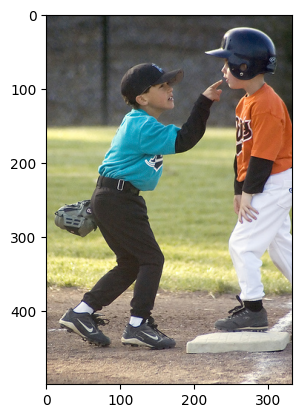

In [28]:
generate_caption("141140165_9002a04f19.jpg")